In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits

from cycspec_simulator import (
    TemplateProfile,
    BasebandModel,
    FreqOnlyPredictor,
    ExponentialScatteringModel,
    Time,
    cycfold_cpu,
)

%matplotlib notebook

In [2]:
template_file = "B1937+21.Rcvr1_2.GUPPI.15y.x.sum.sm"
template = TemplateProfile.from_file(template_file)
template.normalize()
template.make_posdef()

Adjusting I**2 by 5.5361972783884994e-08


In [3]:
pulse_freq = 641.948222127829 # Hz
bandwidth = 1.5625e6 # Hz
predictor = FreqOnlyPredictor(pulse_freq, Time(60000, 0, 0))
model = BasebandModel(template, chan_bw=bandwidth, predictor=predictor)

In [4]:
scattering_model = ExponentialScatteringModel(scattering_time=2e-6, chan_bw=model.chan_bw, cutoff=20)
pattern = scattering_model.realize()

In [5]:
%time data = model.sample(2**19)

CPU times: user 88.3 ms, sys: 5.55 ms, total: 93.9 ms
Wall time: 91.6 ms


In [6]:
%time data_scattered = pattern.scatter(data)

CPU times: user 34.7 ms, sys: 977 µs, total: 35.7 ms
Wall time: 43.9 ms


In [7]:
%time pspec = cycfold_cpu(data_scattered, 128, 256, predictor)

CPU times: user 2.21 s, sys: 20.3 ms, total: 2.23 s
Wall time: 2.23 s


<IPython.core.display.Javascript object>


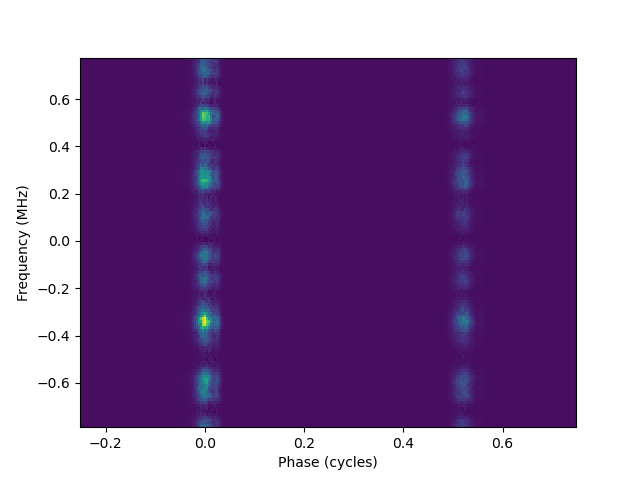

In [8]:
pspec.plot(shift=0.25)
plt.show()